In [2]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter , lfilter, find_peaks
from scipy.fftpack import fft, fftfreq
%matplotlib inline
import pandas as pd

C:\Users\marti\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
'''  MODEL PARAMETERS '''

Cm = 100*pF                    # membrane capacitance
g_leak =10*nS                  # leak conductance
E_rest = -65*mvolt             # membrane rest potential
V_thresh = -52*mvolt           # membrane threshold potential
V_reset = -67*mvolt            # membrane reset potential 
tau_m = 10*ms                  # membrane time constant
tau_r = 1*ms                   # absolute refractory period

E_i  = -75*mvolt               # inhib. reversal potential
E_e  =  0*mvolt                # excit. reversal potential

tau_l = 1*ms                   # time delay 
tau_r_e  = 0.5*ms
tau_d_e  = 2*ms
tau_r_i  = 0.45*ms
tau_d_i  = 1.2*ms

g_peak_e = 1*nS
g_peak_i = 5*nS


N_inhib = 200      # number of inhibitory inter neurons in the network
N_excit = 800      # each inter neuron gets input from 800 excit. neurons.

In [4]:
# def heaviside(t , t0):
#     if t >= t0:
#         return 1
#     else:
#         return 0

In [5]:
defaultclock.dt = 0.05*ms             # choose a particular time step
timestep = 0.05*ms

inp_freq = 10000
sim_time =200

input_rate = (inp_freq/N_excit)*Hz       # total input to each neuron is 5 KHz
alpha = 1 /ms

''' ----------  NEURON EQUATIONS ------------- '''

eqs_model = '''
dv/dt = (g_leak*(E_rest - v) + I_syn )/Cm : volt
I_syn = I_ampa_exc + I_rec : amp
I_ampa_exc = g_peak_e*(E_e - v)*s_ampa_tot : amp
I_rec = g_peak_i*(E_i -v)*s_rec_tot : amp
s_ampa_tot : 1
s_rec_tot  : 1
'''

# (summed): What happens during the simulation is that at each timestep,
# presynaptic variables are summed for each neuron and the result is copied to the variable. 

eqs_ampa = '''
s_ampa_tot_post = w * s_ampa : 1 (summed)
ds_ampa / dt = - s_ampa / tau_d_e + alpha * x * (1 - s_ampa) : 1 (clock-driven)
dx / dt = - x / tau_r_e : 1 (clock-driven)
w : 1
'''
eqs_pre_ampa = '''
x += 1
'''
eqs_rec = '''
s_rec_tot_post = w * s_rec : 1 (summed)
ds_rec / dt = - s_rec / tau_d_i + alpha * y * (1 - s_rec) : 1 (clock-driven)
dy / dt = - y / tau_r_i : 1 (clock-driven)
w : 1
'''
eqs_pre_rec = '''
y += 1
'''
#clip(gi, 0, g_peak_i)
P = PoissonGroup(8400, rates=input_rate)

G = NeuronGroup(N_inhib, eqs_model, threshold='v> V_thresh', reset='v = V_reset', method ='euler')

# 'model=' for Synapses: used when you want it to happen every timestep.

# Excitatory Synapse Group
S_excit = Synapses(P,G, model=eqs_ampa , on_pre= eqs_pre_ampa , delay = tau_l , method = 'euler')
S_excit.connect(p=0.095)
S_excit.w = 1.0
# Inhibitory, Recurrent Synapse Group

S_inhib = Synapses(G,G,model=eqs_rec , on_pre= eqs_pre_rec , delay = tau_l , method = 'euler')
S_inhib.connect(condition='i!=j', p=0.2)
# set inhib weights to 1.0 as well
S_inhib.w = 1.0
# Spike, State Monitors

State_Mon = StateMonitor(G, 'v',record=True)
Spike_Mon = SpikeMonitor(G)

# Record instantaneous ﬁring rates, averaged across neurons from a NeuronGroup or other spike source.
# To get a smoother version of the rate, use PopulationRateMonitor.smooth_rate().
Rate_Mon = PopulationRateMonitor(G)

# initialise at rest 
G.v = E_rest
print('Before v = %s' % G.v[0])
run(200*ms)
print('After v = %s' % G.v[0])

cl : Command line warning D9025 : overriding '/W3' with '/w'
WARNING    Cannot use Cython, a test compilation failed: command 'C:\\Program Files (x86)\\Microsoft Visual Studio\\2019\\Community\\VC\\Tools\\MSVC\\14.25.28610\\bin\\HostX86\\x64\\cl.exe' failed with exit status 2 (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


_cython_magic_ea19c5de6fe48070c44050510ef3e720.cpp
C:\Users\marti\anaconda3\include\pyconfig.h(59): fatal error C1083: Cannot open include file: 'io.h': No such file or directory
Before v = -65. mV
After v = -55.10916862 mV


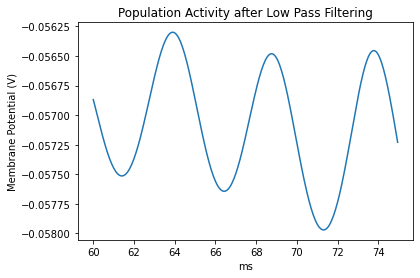

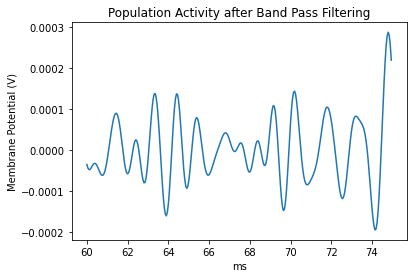

In [8]:
def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = False)
    return b, a

def butter_lowpass_filter(data, cutOff, fs, order=4):
    b, a = butter_lowpass(cutOff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

fs  = 5_000

v_lp = butter_lowpass_filter(v_pop, 50, fs)    # low pass filtering 

plot( T[1000:1300], v_lp[1000:1300])
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.title('Population Activity after Low Pass Filtering')
plt.show()

v_bp = butter_bandpass_filter(v_pop, lowcut=140 ,highcut=300, fs = fs)

plot( T[1000:1300], v_bp[1000:1300])
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.title('Population Activity after Band Pass Filtering')
plt.show()

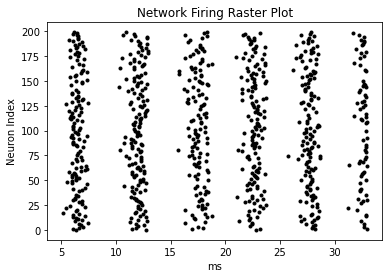

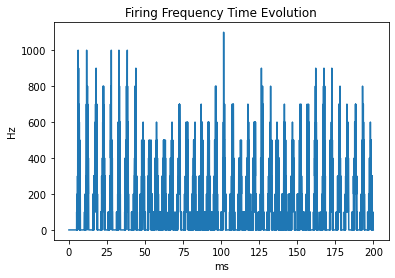

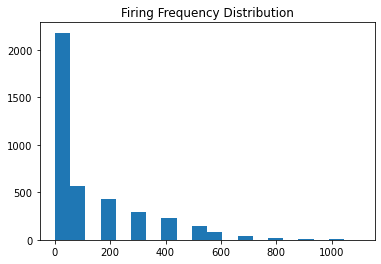

In [9]:
plot((Spike_Mon.t/ms)[0:800], (Spike_Mon.i)[0:800] , '.k')
xlabel('ms')
ylabel('Neuron Index')
plt.title('Network Firing Raster Plot')

figure()
plot(Rate_Mon.t/ms, Rate_Mon.rate/Hz )
plt.title('Firing Frequency Time Evolution')
xlabel('ms')
ylabel('Hz')

plt.show()
plt.hist(Rate_Mon.rate/Hz , bins = 20)
plt.title('Firing Frequency Distribution')
plt.show()

# population spike count vs time --> mean, std,

# TINCHO

## Observe the spiking behavior of individual neurons.

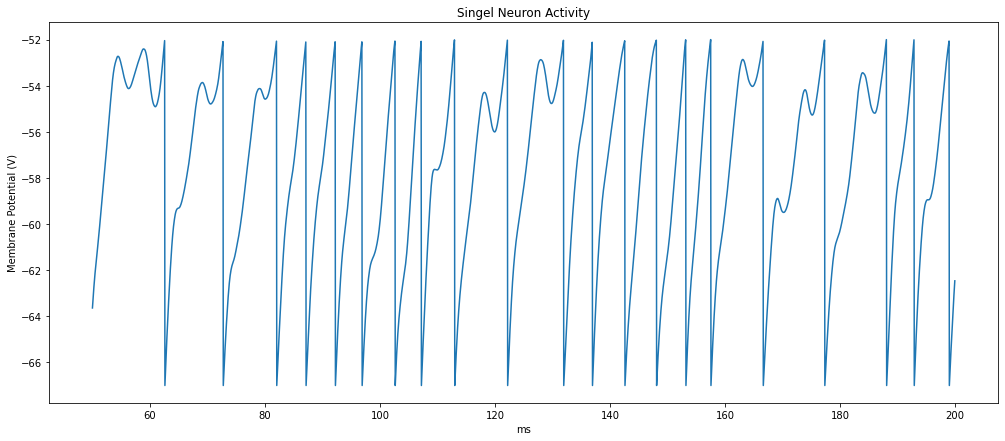

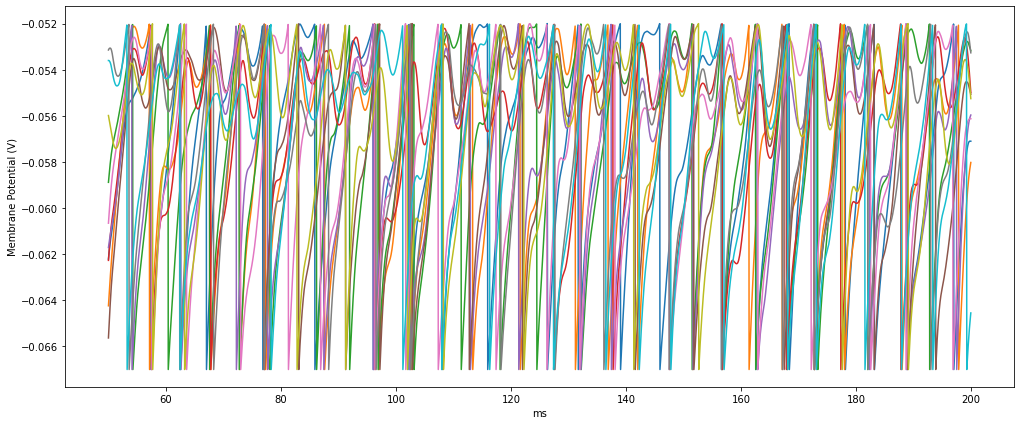

In [23]:

plt.figure(figsize=(17,7))
plot((State_Mon.t[:]/ms)[1000:20000], (State_Mon.v[np.random.randint(N_inhib)])[1000:20000]/mV)
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.title('Singel Neuron Activity')
plt.show()

plt.figure(figsize=(17,7))
for i in range(10):
    plot((State_Mon.t[:]/ms)[1000:5000], (State_Mon.v[np.random.randint(N_inhib)][:])[1000:5000])
xlabel('ms')
ylabel('Membrane Potential (V)')
plt.show()

## How are the firing rates of individual interneurons distributed?

The mean of the rate of all the neurons is 125.4


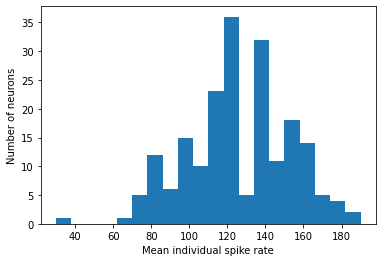

In [31]:
inp_freq = 10000
sim_time =200
spike=np.zeros(200)
for j in range(0,200): 
    spike[j]=sum((Spike_Mon.i==j)*1)/(sim_time/1000)

plt.hist(spike,bins=20)
plt.xlabel('Mean individual spike rate')
plt.ylabel('Number of neurons')
print('The mean of the rate of all the neurons is ' +str(np.mean(spike)))

We can see here, that all neurons have a mean rate over the whole 3 seconds of 42 Hertz, oscillating depending on the index

## Observe the population activity.

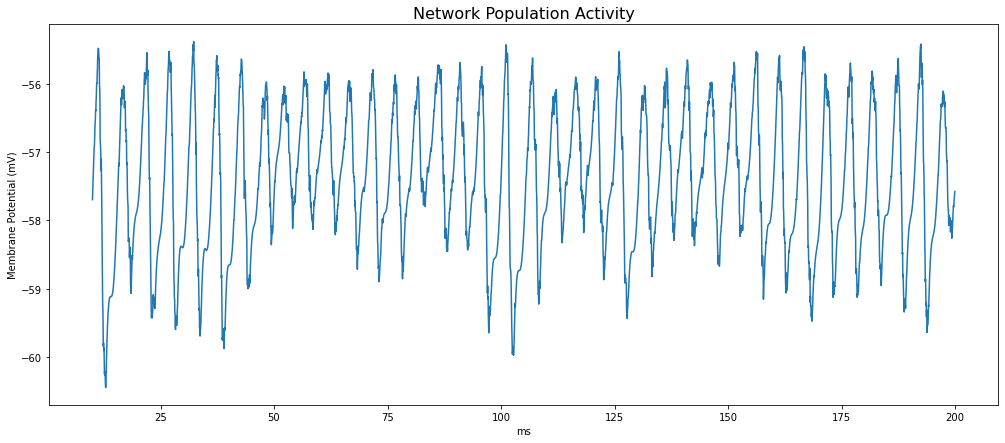

(0.0, 1000.0)

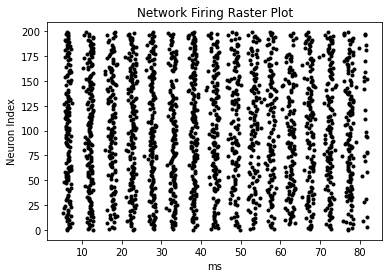

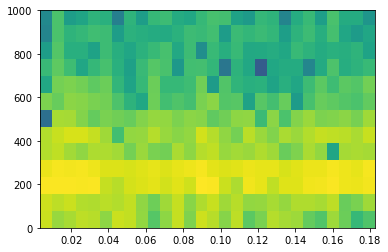

In [12]:
T = State_Mon.t[200:]/ms
v_pop = np.mean(State_Mon.v , axis = 0)[200:]     # population level average

plt.figure(figsize=(17,7))
plot(T, v_pop/mV )
xlabel('ms')
ylabel('Membrane Potential (mV)')
plt.title('Network Population Activity',fontsize=16)
plt.show()

plot((Spike_Mon.t/ms)[0:2000], (Spike_Mon.i)[0:2000] , '.k')
xlabel('ms')
ylabel('Neuron Index')
plt.title('Network Firing Raster Plot');

figure()
plt.specgram(v_pop/mV-np.mean(v_pop/mV),Fs=1000/(T[1]-T[0]));
plt.ylim([0,1000])

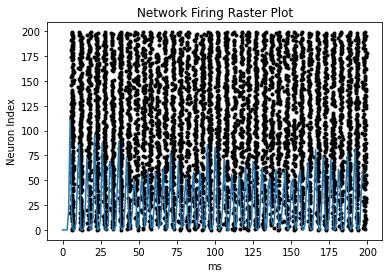

In [22]:
plot((Spike_Mon.t/ms), (Spike_Mon.i) , '.k')
xlabel('ms')
ylabel('Neuron Index')
plt.title('Network Firing Raster Plot');
plt.plot(spikes[2::])

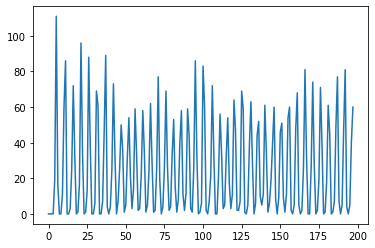

In [21]:
win = 1
window = np.arange(0,200,win)
times=Spike_Mon.t/ms
spikes = np.zeros(len(window))


# spikes[0]= np.sum((times\ms<window[0])*1)
for i in range(1,len(spikes)):
    spikes[i]=sum((times<window[i])*1-(times<window[i-1])*1)
    
plt.plot(spikes[2::])

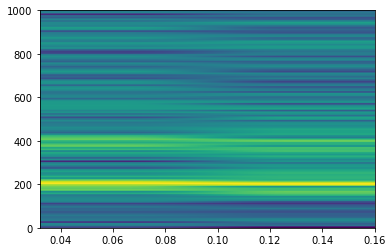

In [18]:
plt.specgram(spikes-np.mean(spikes),Fs=1000/win);

## Trying to find ripples.

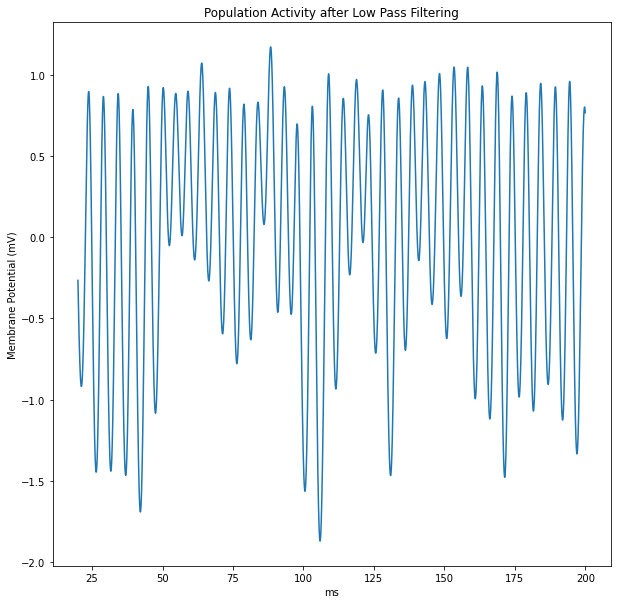

In [15]:
fs  = 5_000

fig = plt.figure(figsize=(10,10))

v_lp = butter_lowpass_filter(v_pop, 50, fs)    # low pass filtering 

plot( T[200::], (v_lp[200::]-np.mean(v_lp[200::]))/mV)
xlabel('ms')
ylabel('Membrane Potential (mV)')
plt.title('Population Activity after Low Pass Filtering')
plt.show()

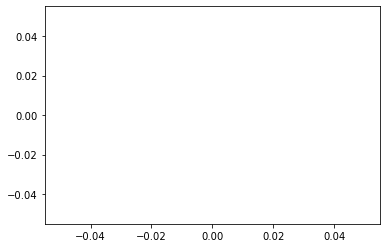

In [16]:
new_vlp = -(v_lp[200::]-np.mean(v_lp[200::]))/mV
ripple=find_peaks(new_vlp,height=1)
plt.plot(new_vlp[ripple[0][0]-500:ripple[0][0]+500])

In [ ]:
np.mean(v_lp[200::])

In [ ]:
# Now let's inspect that ripple without the LP:
v_pop1 = -(v_pop[200::]-np.mean(v_pop))/mV
v_ripp = v_pop1[ripple[0][0]-500:ripple[0][0]+500]
plt.plot(T[ripple[0][0]-500:ripple[0][0]+500],v_ripp)

In [ ]:
# We have localized the ripple now in the middle of this interval. Let's Bandpass it now.
v_bp = butter_bandpass_filter(v_ripp, lowcut=150 ,highcut=300, fs = fs)

plt.plot(v_bp)